In [1]:
import os
import glob
import numpy as np
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import scipy.io
from torch.utils.data import Dataset, DataLoader

In [8]:
def hmdb51Files(dataFolder):
    # 获取所有视频文件的路径
    videoPaths = glob.glob(os.path.join(dataFolder, '*', '*.avi'))
    # print(videoPaths)
    # 获取所有视频文件的标签
    labels = [os.path.basename(os.path.dirname(p)) for p in videoPaths]
    # 将标签转换为数字编码
    labelToIdx = {label: idx for idx, label in enumerate(sorted(set(labels)))}
    labels = [labelToIdx[label] for label in labels]
    # 将视频文件路径和标签合并为一个列表
    files = list(zip(videoPaths, labels))
    # 将列表随机打乱
    np.random.shuffle(files)
    # 返回视频文件路径和标签
    return files, labels


def get_tensor_from_video(video_path):
    """
    :param video_path: 视频文件地址
    :return: pytorch tensor
    """
    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    if not os.access(video_path, os.F_OK):
        print('测试文件不存在')
        return

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frames_list = []
    
    while(cap.isOpened()):
        ret,frame = cap.read()
        if not ret:
            break
        else:
            # 注意，opencv默认读取的为BGR通道组成模式，需要转换为RGB通道模式
            frame_count += 1
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = transform(frame).cuda()
            frames_list.append(frame)
    cap.release()

    # 转换成tensor
    result_frames = torch.stack(frames_list, dim=0)
    result_frames = result_frames.float()
    # 注意：此时result_frames组成的维度为[视频帧数量，宽，高，通道数]
    return result_frames

In [9]:
dataFolder = "hmdb51_org"
files, labels = hmdb51Files(dataFolder)

In [3]:
# Load the pre-trained ResNet50 model
resnet = models.resnet18(pretrained=True).cuda()

# Remove the last layer of the ResNet50 model to obtain the feature extractor
resnet_feat = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

In [3]:
# Create an empty list to store the features and labels
samples = []

numFiles = len(files)
for i in range(numFiles):
    print("Reading file %d of %d...\n" % (i,numFiles))
    
    video = get_tensor_from_video(files[i][0])
    
    # Extract the features using the pre-trained ResNet50 model
    with torch.no_grad():
        features_tensor = resnet_feat(video)
        # print(features_tensor.shape)
    # Flatten the features tensor
    features_tensor = torch.flatten(features_tensor, start_dim=1)
    # Convert the features tensor to a numpy array
    features = features_tensor.cpu().numpy()
    # Append the features and label to the samples list
    samples.append((features, files[i][1]))

# Shuffle the samples list
np.random.shuffle(samples)

# Split the samples into training and testing sets
split_idx = int(0.9 * len(samples))
train_samples = samples[:split_idx]
test_samples = samples[split_idx:]

In [9]:
# Separate the features and labels into separate arrays for training and testing sets
train_features, train_labels = zip(*train_samples)
test_features, test_labels = zip(*test_samples)

In [10]:
# Convert the features and labels arrays to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)


# Print the shapes of the features and labels arrays
print("Train Features shape:", train_features.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Features shape:", test_features.shape)
print("Test Labels shape:", test_labels.shape)


# Save the features and labels to numpy arrays
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

/tmp/ipykernel_807/567465983.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_features = np.array(train_features)
/tmp/ipykernel_807/567465983.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_features = np.array(test_features)


Train Features shape: (6089,)
Train Labels shape: (6089,)
Test Features shape: (677,)
Test Labels shape: (677,)


In [2]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [12]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out

In [75]:
class MultiLayerBiLSTMClassifierAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size*2, hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, num_classes) # *2 to account for bidirectional LSTM
        self.BN = nn.BatchNorm1d(17)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device) # *2 to account for bidirectional LSTM
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device) # *2 to account for bidirectional LSTM

        # Forward propagate bidirectional LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        # out = self.BN(out)
        attention_weights = torch.softmax(self.attention(out),dim = 1)
        #计算注意力向量
        attn_vectors = torch.bmm(attention_weights.transpose(1, 2), out)
        #将注意力向量和LSTM输出相加并通过线性层得到最终输出
        out = torch.relu(attn_vectors.squeeze(1))
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out

In [8]:
class MultiLayerBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes) # *2 to account for bidirectional LSTM
        self.BN = nn.BatchNorm1d(18)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device) # *2 to account for bidirectional LSTM
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device) # *2 to account for bidirectional LSTM
        # Forward propagate bidirectional LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = self.BN(out)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out

In [5]:
# t_f = np.load('train_features.npy',allow_pickle=True)
# # 截取视频的前17帧用来进行训练
# lt_f = t_f.shape[0]
# for i in range(lt_f):
#     t_f[i] = t_f[i][0:17].astype(float)

In [22]:
# # Load the features and labels from numpy arrays
# train_features = torch.Tensor(list(t_f)).float()
# train_labels = torch.from_numpy(np.load('train_labels.npy',allow_pickle=True))#.long()
# idx = np.random.permutation(len(train_features))
# train_features, train_labels = train_features[idx], train_labels[idx]

In [7]:
# te_f = np.load('test_features.npy',allow_pickle=True)
# lte_f = te_f.shape[0]
# for i in range(lte_f):
#     te_f[i] = te_f[i][0:17].astype(float)

In [8]:
# test_features = torch.Tensor(list(te_f)).float()
# test_labels = torch.from_numpy(np.load('test_labels.npy'))#.long()

In [4]:
class trainDataset(Dataset):
    def __init__(self,filepath):
        t_f = np.load('train_features.npy',allow_pickle=True)
        # 截取视频的前17帧用来进行训练
        lt_f = t_f.shape[0]
        for i in range(lt_f):
            t_f[i] = t_f[i][0:18].astype(float)
        
        # Load the features and labels from numpy arrays
        train_features = torch.Tensor(list(t_f)).float()
        train_labels = torch.from_numpy(np.load('train_labels.npy',allow_pickle=True))#.long()
        idx = np.random.permutation(len(train_features))
        train_features, train_labels = train_features[idx], train_labels[idx]
        self.len = train_features.shape[0]
        self.x_data = train_features
        self.y_data = train_labels
 
    # getitem函数，可以使用索引拿到数据
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
 
    # 返回数据的条数/长度
    def __len__(self):
        return self.len

dataset = trainDataset("")

train_loader = DataLoader(dataset=dataset,
                          batch_size=32,
                          shuffle=True)

/tmp/ipykernel_860/4029391957.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  train_features = torch.Tensor(list(t_f)).float()


In [5]:
class testDataset(Dataset):
    def __init__(self,filepath):
        te_f = np.load('test_features.npy',allow_pickle=True)
        lte_f = te_f.shape[0]
        for i in range(lte_f):
            te_f[i] = te_f[i][0:18].astype(float)
        
        # Load the features and labels from numpy arrays
        test_features = torch.Tensor(list(te_f)).float()
        test_labels = torch.from_numpy(np.load('test_labels.npy'))#.long()
        idx = np.random.permutation(len(test_features))
        test_features, test_labels = test_features[idx], test_labels[idx]
        self.len = test_features.shape[0]
        self.x_data = test_features
        self.y_data = test_labels
 
    # getitem函数，可以使用索引拿到数据
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
 
    # 返回数据的条数/长度
    def __len__(self):
        return self.len

test_dataset = testDataset("")

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=True)

In [9]:
# Define the LSTM parameters
input_size = 512
hidden_size = 196
num_classes = 51

# Instantiate the LSTM model
model = MultiLayerBiLSTMClassifier(input_size, hidden_size, 2, num_classes).cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the LSTM model
num_epochs = 120
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
t_test_acc = 0

for epoch in range(50):
    # Training
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    for _,train_features in enumerate(train_loader, 0):
        # Get a batch of 15 frames features and labels
        batch_features = train_features[0].cuda()
        batch_labels = train_features[1].cuda()
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        # Accumulate training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += batch_features.shape[0]
        train_correct += (predicted == batch_labels).sum().item()
    train_loss /= train_total
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        for _,test_features in enumerate(test_loader, 0):
            # Get a batch of 15 frames features and labels
            batch_features = test_features[0].cuda()
            batch_labels = test_features[1].cuda()
            # Forward
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            # Accumulate testing loss and accuracy
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += batch_features.shape[0]
            test_correct += (predicted == batch_labels).sum().item()
            # Calculate testing accuracy
        test_accuracy = test_correct / test_total
        test_loss /= test_total
        test_accuracy = 100* test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        if(test_accuracy > t_test_acc):
            t_test_acc = test_accuracy
            torch.save(model.state_dict(), "cnn_bilstm_highest_acc_h128_atten.pth")
            print("save successfully,t_acc is {:.4f}%".format(t_test_acc))
            
        # Print testing loss and accuracy
        print('Train Loss: {:.4f}, Train Accuracy: {:.2f}%  Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format( train_loss, train_accuracy, test_loss, test_accuracy))

save successfully,t_acc is 21.7134%
Train Loss: 0.1205, Train Accuracy: 12.86%  Test Loss: 0.1224, Test Accuracy: 21.71%
save successfully,t_acc is 29.9852%
Train Loss: 0.1167, Train Accuracy: 26.84%  Test Loss: 0.1195, Test Accuracy: 29.99%
save successfully,t_acc is 38.8479%
Train Loss: 0.1139, Train Accuracy: 36.11%  Test Loss: 0.1173, Test Accuracy: 38.85%
save successfully,t_acc is 45.6425%
Train Loss: 0.1115, Train Accuracy: 44.80%  Test Loss: 0.1158, Test Accuracy: 45.64%
save successfully,t_acc is 48.7445%
Train Loss: 0.1095, Train Accuracy: 50.50%  Test Loss: 0.1142, Test Accuracy: 48.74%
save successfully,t_acc is 50.0739%
Train Loss: 0.1080, Train Accuracy: 55.44%  Test Loss: 0.1139, Test Accuracy: 50.07%
save successfully,t_acc is 51.9941%
Train Loss: 0.1065, Train Accuracy: 59.85%  Test Loss: 0.1131, Test Accuracy: 51.99%
Train Loss: 0.1054, Train Accuracy: 63.21%  Test Loss: 0.1131, Test Accuracy: 51.55%
save successfully,t_acc is 53.9143%
Train Loss: 0.1044, Train Accura

In [11]:
model1 = MultiLayerBiLSTMClassifier(input_size, hidden_size, 2, num_classes).cuda()
model1.load_state_dict(torch.load("cnn_bilstm_highest_acc_h128_atten.pth"))

<All keys matched successfully>

In [12]:
conf_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
        for _,test_features in enumerate(test_loader, 0):
            # Get a batch of 15 frames features and labels
            batch_features = test_features[0].cuda()
            batch_labels = test_features[1].cuda()
            # Forward
            outputs = model1(batch_features)
            _, p = torch.max(outputs, 1)
            #记录混淆矩阵参数
            length = p.shape[0]
            for i in range(length):
                conf_matrix[p[i].item(),batch_labels[i].item()]+=1

conf_matrix=np.array(conf_matrix.cpu())# 将混淆矩阵从gpu转到cpu再转到np

corrects=conf_matrix.diagonal(offset=0)#抽取对角线的每种分类的识别正确个数
per_kinds=conf_matrix.sum(axis=1)#抽取每个分类数据总的测试条数

print("混淆矩阵总元素个数：{0},测试集总个数:{1}".format(int(np.sum(conf_matrix)),len(test_features)))
np.set_printoptions(threshold=np.inf)
print(conf_matrix)

混淆矩阵总元素个数：677,测试集总个数:2
[[ 5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 11.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  

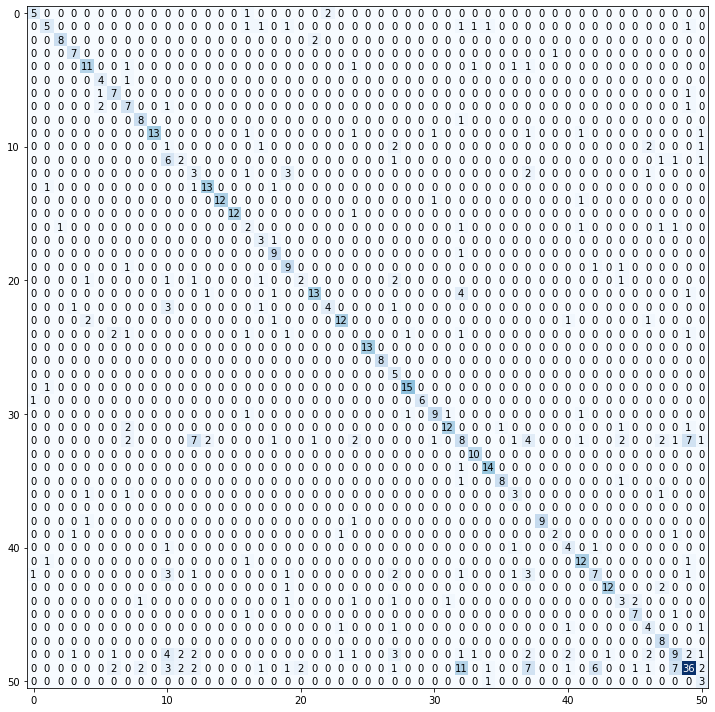

In [13]:
# 显示数据
plt.figure(figsize=(10,10))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)


# 在图中标注数量/概率信息
thresh = conf_matrix.max() / 2	#数值颜色阈值，如果数值超过这个，就颜色加深。
for x in range(51):
    for y in range(51):
        # 注意这里的matrix[y, x]不是matrix[x, y]
        info = int(conf_matrix[y, x])
        plt.text(x, y, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")
                 
plt.tight_layout()#保证图不重叠